In [82]:
from typing import Tuple, List, Dict
from collections import defaultdict

from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2, SamplerV2

from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import dimod
import dwave.inspector

In [2]:
N = 4 # the side of the board

In [19]:
Cell = Tuple[int, int]
Mapping = Dict[Cell, int]

In [ ]:
def get_attacks_for_each_cell(cell:Cell) -> List[Cell]:
    """
    Check the attacks for each queen position.
    """

    current_row, current_col = cell

    attacks = []


    for k in range(N):
        current_mapped_col = (k, current_col)
        current_mapped_row = (current_row, k)

        if current_mapped_row != cell:
            attacks.append(current_mapped_row)
        
        if current_mapped_col != cell:
            attacks.append(current_mapped_col)


    # top left
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j > 0:
        current_i -= 1
        current_j -= 1
        attacks.append((current_i, current_j))

    # bottom right
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j < N-1:
        current_i += 1
        current_j += 1
        attacks.append((current_i, current_j))

    # top right 
    current_i = current_row
    current_j = current_col
    while current_i > 0 and current_j < N-1:
        current_i -= 1
        current_j += 1
        attacks.append((current_i, current_j))

    # bottom left 
    current_i = current_row
    current_j = current_col
    while current_i < N-1 and current_j > 0:
        current_i += 1
        current_j -= 1
        attacks.append((current_i, current_j))

    return attacks

In [20]:
def get_pos_mapping() -> Mapping:
    mapping = {}
    k = 0
    for i in range(N):
        for j in range(N):
            mapping[(i,j)] = k
            k += 1
    return mapping

In [62]:
def get_qubo(mapping:Mapping) -> dimod.BinaryQuadraticModel:

    model = dimod.BinaryQuadraticModel(vartype='BINARY')

    constraints = []
    constraint_total_vars = [(f'x{i}',1) for i in mapping.values()]

    for i in range(N):
        constraints.append([])

        for j in range(N):
            pos = (i,j)
            current_pos_map = mapping[pos]
            attacks = get_attacks_for_each_cell(pos)

            for attack in attacks:
                mapped_pos = mapping[attack]
                model.add_quadratic(f'x{mapped_pos}', f'x{current_pos_map}', 1)
            
            # constraint for each board row
            constraints[-1].append((f'x{current_pos_map}', 1))

    for constraint in constraints:
        model.add_linear_equality_constraint(constraint, N*N, -1)
    model.add_linear_equality_constraint(constraint_total_vars, N*N, -1 * N)

    return model

             

In [63]:
mapping = get_pos_mapping()
qubo = get_qubo(mapping)
qubo

BinaryQuadraticModel({'x1': -128.0, 'x0': -128.0, 'x4': -128.0, 'x2': -128.0, 'x8': -128.0, 'x3': -128.0, 'x12': -128.0, 'x5': -128.0, 'x10': -128.0, 'x15': -128.0, 'x9': -128.0, 'x13': -128.0, 'x6': -128.0, 'x11': -128.0, 'x14': -128.0, 'x7': -128.0}, {('x0', 'x1'): 66.0, ('x4', 'x1'): 34.0, ('x4', 'x0'): 34.0, ('x2', 'x1'): 66.0, ('x2', 'x0'): 66.0, ('x2', 'x4'): 32.0, ('x8', 'x1'): 32.0, ('x8', 'x0'): 34.0, ('x8', 'x4'): 34.0, ('x8', 'x2'): 34.0, ('x3', 'x1'): 66.0, ('x3', 'x0'): 66.0, ('x3', 'x4'): 32.0, ('x3', 'x2'): 66.0, ('x3', 'x8'): 32.0, ('x12', 'x1'): 32.0, ('x12', 'x0'): 34.0, ('x12', 'x4'): 34.0, ('x12', 'x2'): 32.0, ('x12', 'x8'): 34.0, ('x12', 'x3'): 34.0, ('x5', 'x1'): 34.0, ('x5', 'x0'): 34.0, ('x5', 'x4'): 66.0, ('x5', 'x2'): 34.0, ('x5', 'x8'): 34.0, ('x5', 'x3'): 32.0, ('x5', 'x12'): 32.0, ('x10', 'x1'): 32.0, ('x10', 'x0'): 34.0, ('x10', 'x4'): 32.0, ('x10', 'x2'): 34.0, ('x10', 'x8'): 66.0, ('x10', 'x3'): 32.0, ('x10', 'x12'): 32.0, ('x10', 'x5'): 34.0, ('x15', 'x

In [64]:
sampler = dimod.ExactSolver()
sampleset = sampler.sample(qubo)
#dwave.inspector.show(sampleset)
sampleset

SampleSet(rec.array([([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 320., 1),
           ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 192., 1),
           ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 130., 1),
           ...,
           ([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  66., 1),
           ([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  96., 1),
           ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 192., 1)],
          dtype=[('sample', 'i1', (16,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(['x0', 'x1', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']), {}, 'BINARY')

In [65]:
df = sampleset.to_pandas_dataframe()
best_solutions = df[df['energy'] == df['energy'].min()]
best_solutions

,x0,x1,x10,x11,x12,x13,x14,x15,x2,x3,x4,x5,x6,x7,x8,x9,energy,num_occurrences
12296,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0.0,1
32798,0,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0.0,1


In [70]:
df.to_csv("qubo-solution.csv")

In [66]:
def get_board_from_row(mapping:Mapping, row:pd.Series):
    matrix = [[0]*N for i in range(N)]

    for i in range(N):
        for j in range(N):
            mapped_pos = mapping[(i,j)]
            matrix[i][j] = row[f'x{mapped_pos}']
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.show()

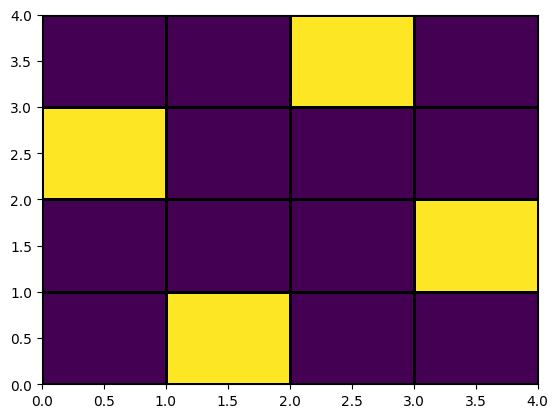

In [69]:
get_board_from_row(mapping, best_solutions.iloc[1])

---

In [73]:
def get_obs(total_qubits:int, qubits:List[int]) -> str:
    obs = ['I']*total_qubits
    for qubit in qubits:
        obs[qubit] = 'Z'
    return ''.join(obs)

In [92]:
def get_H(mapping:Mapping, P:int) -> SparsePauliOp:
  
    total_qubits = len(mapping)

    base_multiplier = 1/4
    constant_counter = 0

    lookup = defaultdict(float) # how obs and coeffs


    for i in range(N):

        line_qubits = []
        for j in range(N):
            pos = (i,j)
            current_pos_map = mapping[pos]
            line_qubits.append(current_pos_map)
            attacks = get_attacks_for_each_cell(pos)

            constant_counter += len(attacks)

            for attack in attacks:
                mapped_pos = mapping[attack]

                attack_obs_joint = get_obs(total_qubits, [current_pos_map, mapped_pos])
                ind_1_obs = get_obs(total_qubits, [current_pos_map])
                ind_2_obs = get_obs(total_qubits, [mapped_pos])

                constant_counter += base_multiplier

                lookup[attack_obs_joint] += base_multiplier
                lookup[ind_1_obs] += base_multiplier
                lookup[ind_2_obs] += base_multiplier

        lookup[get_obs(total_qubits, line_qubits)] += P * ((-1*total_qubits) + 1) # only one per row

    # maximium of N choices
    lookup[get_obs(total_qubits, list(range(total_qubits)))] += P * (-1 * (-1 * (total_qubits-N)) + N)
    



    return SparsePauliOp.from_list(lookup.items())
    



In [95]:
Hamiltonian = get_H(mapping, 10)
Hamiltonian

SparsePauliOp(['ZZIIIIIIIIIIIIII', 'ZIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIII', 'IIIIZIIIIIIIIIII', 'ZIZIIIIIIIIIIIII', 'IIZIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIII', 'IIIIIIIIZIIIIIII', 'ZIIZIIIIIIIIIIII', 'IIIZIIIIIIIIIIII', 'ZIIIIIIIIIIIZIII', 'IIIIIIIIIIIIZIII', 'ZIIIIZIIIIIIIIII', 'IIIIIZIIIIIIIIII', 'ZIIIIIIIIIZIIIII', 'IIIIIIIIIIZIIIII', 'ZIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIZ', 'IZIIIZIIIIIIIIII', 'IZZIIIIIIIIIIIII', 'IZIIIIIIIZIIIIII', 'IIIIIIIIIZIIIIII', 'IZIZIIIIIIIIIIII', 'IZIIIIIIIIIIIZII', 'IIIIIIIIIIIIIZII', 'IZIIIIZIIIIIIIII', 'IIIIIIZIIIIIIIII', 'IZIIIIIIIIIZIIII', 'IIIIIIIIIIIZIIII', 'IZIIZIIIIIIIIIII', 'IIZIIIZIIIIIIIII', 'IIZIIIIIIIZIIIII', 'IIZZIIIIIIIIIIII', 'IIZIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIZI', 'IIZIIIIZIIIIIIII', 'IIIIIIIZIIIIIIII', 'IIZIIZIIIIIIIIII', 'IIZIIIIIZIIIIIII', 'IIIZIIIZIIIIIIII', 'IIIZIIIIIIIZIIII', 'IIIZIIIIIIIIIIIZ', 'IIIZIIZIIIIIIIII', 'IIIZIIIIIZIIIIII', 'IIIZIIIIIIIIZIII', 'ZZZZIIIIIIIIIIII', 'IIIIZZIIIIIIIIII', 'IIIIZIZIIIIIIIII', 'IIII

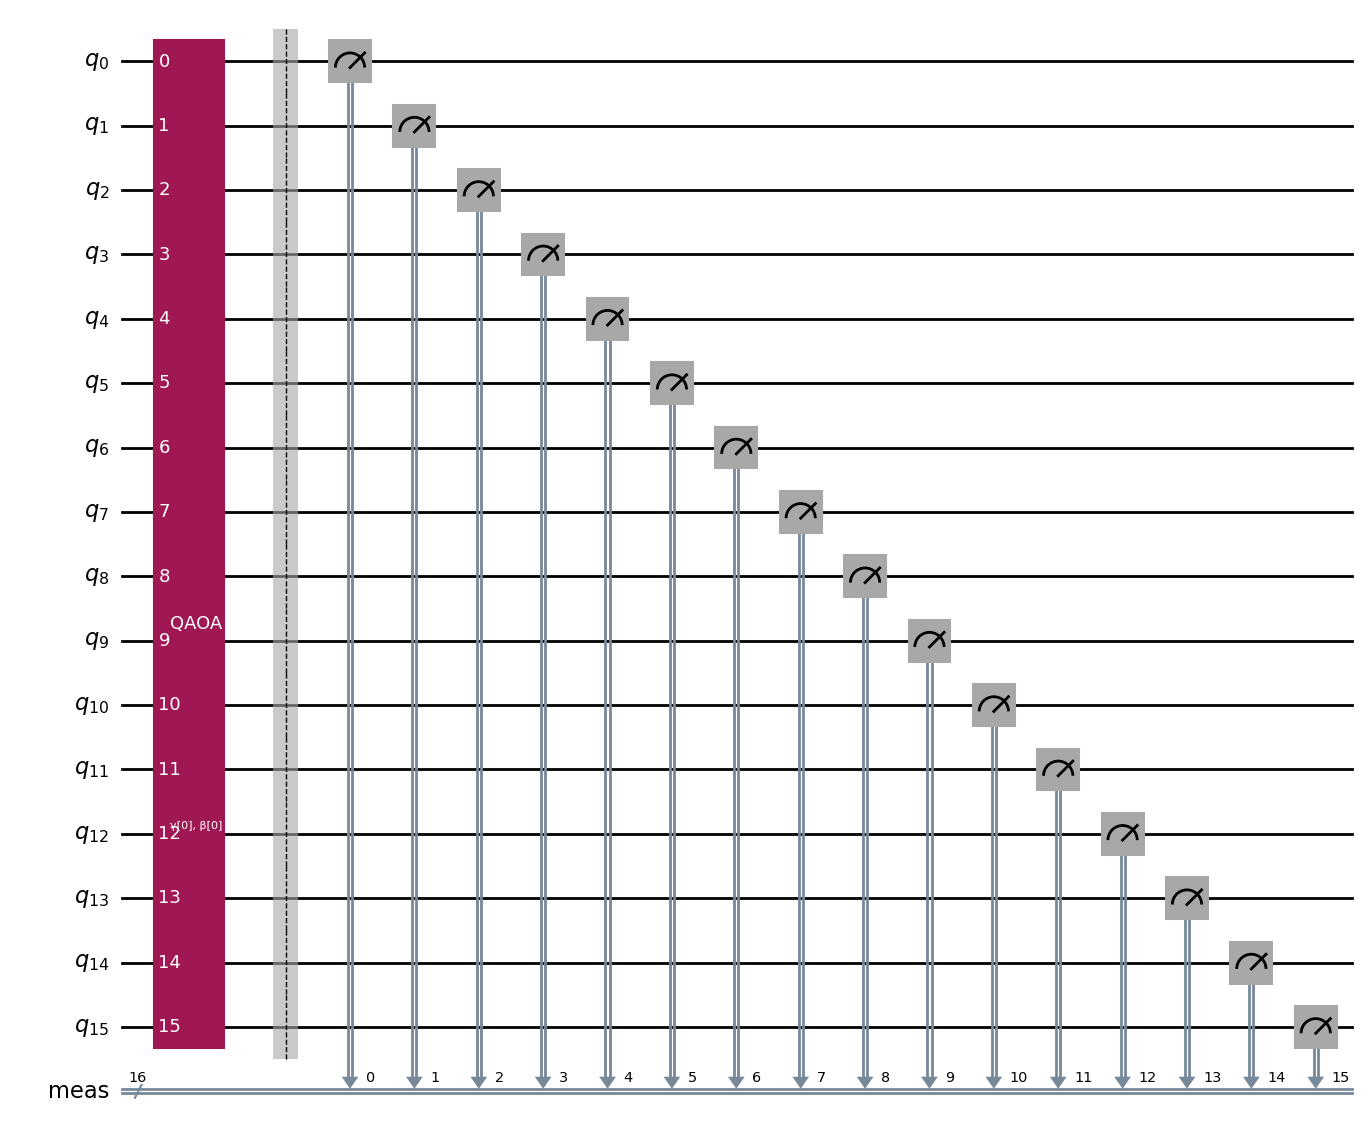

In [ ]:

qaoa = QAOAAnsatz(cost_operator=Hamiltonian,reps=1)
qaoa.measure_all()
qaoa.draw('mpl')

In [102]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
isa_qc = pm.run(qaoa)

In [103]:
Params = List[float]
History = List[float]
def cost_func(params:Params, ansatz:QuantumCircuit, hamiltonian:SparsePauliOp, estimator:EstimatorV2, history:History) -> float:
    """Get the cost of the current circuit"""
    isa_h = hamiltonian.apply_layout(ansatz.layout)
    
    job = estimator.run([(ansatz, isa_h, params)])

    results = job.result()[0]
    cost = results.data.evs

    history.append(cost)
    print("Current cost: ", cost)

    return cost

In [104]:
history = []
estimator = EstimatorV2()
init_params = np.random.uniform(low=0.0, high=np.pi, size=(1,len(isa_qc.parameters)))[0]
result = minimize(
        cost_func,
        init_params,
        args=(isa_qc, Hamiltonian, estimator, history),
        method="COBYLA",
        tol=1e-2,
    )

Current cost:  4.185546875000002
Current cost:  11.228515625
Current cost:  -30.62890625
Current cost:  22.486328125
Current cost:  -44.25
Current cost:  -4.507812499999999
Current cost:  -13.240234375
Current cost:  -31.11328125
Current cost:  -45.671875
Current cost:  168.28515625
Current cost:  16.275390625
Current cost:  -77.419921875
Current cost:  -13.148437499999998
Current cost:  -271.93359375
Current cost:  -73.0234375
Current cost:  -207.04296875
Current cost:  -272.091796875
Current cost:  -250.603515625
Current cost:  -182.81640625
Current cost:  -208.50390625
Current cost:  105.533203125
Current cost:  -262.04296875


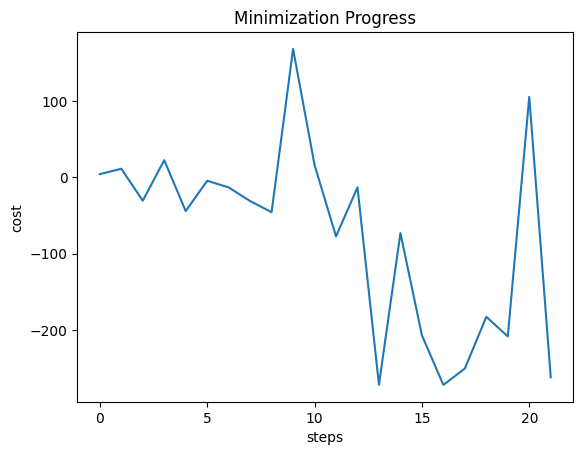

In [105]:
plt.title("Minimization Progress")
plt.plot(list(range(len(history))), history)
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

In [106]:
print(result.x)
answer_qc = isa_qc.assign_parameters(result.x)

[2.87226117 3.48322419]


In [107]:
sampler = SamplerV2()
job = sampler.run([answer_qc], shots=1000)
bit_strings = job.result()[0].data.meas.get_counts()
bit_strings

{'0110001100000000': 1,
 '1001111100000110': 1,
 '0000100100001111': 1,
 '0000101000100101': 1,
 '0100000010011111': 1,
 '1010010110100101': 1,
 '1111000110100110': 1,
 '0011001111111111': 1,
 '1111111100000110': 1,
 '1100000010001100': 1,
 '1111010111110011': 1,
 '0111111101011001': 1,
 '1110100100111110': 1,
 '0101101101011111': 1,
 '0000111110100000': 1,
 '0001000000100000': 1,
 '0101001111111101': 1,
 '1010011010100101': 1,
 '0000010000000001': 1,
 '0101011011111110': 1,
 '0100000010001100': 1,
 '1111000000000100': 1,
 '0001001011101001': 1,
 '0011101010101001': 1,
 '0110001111001001': 1,
 '0011010100001010': 1,
 '1010001101101111': 1,
 '1101001010110100': 1,
 '0110000000000010': 1,
 '0101010110011101': 1,
 '1001110011110000': 2,
 '0000101011011111': 1,
 '1110011011001100': 1,
 '1111001100010100': 1,
 '1111100010101011': 1,
 '0011001001010110': 1,
 '1010000001101111': 1,
 '1111100110001111': 1,
 '0100010110010110': 1,
 '1101000000010001': 1,
 '0011100101101100': 1,
 '00101101110000

In [108]:
def solution_board(bit_string:str):
    matrix = []

    qubit = 0
    for i in range(N):
        matrix.append([])
        for j in range(N):
            matrix[-1].append(int(bit_string[qubit]))
            qubit += 1
    
    plt.pcolormesh(matrix,edgecolors="k",linewidth=2)
    plt.show()

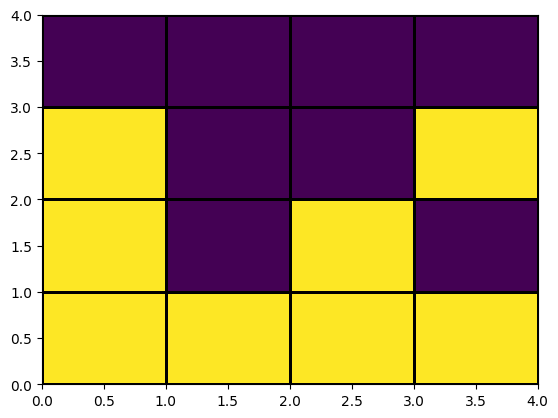

In [109]:
best_solution = max(bit_strings.items(), key=lambda x: x[-1])[0]
solution_board(best_solution)